# Additional Puffer Analysis

These experiments are run with the other replay experiments, see [the Puffer replay notebook](./puffer-replay.ipynb) for more info. This notebook can be used to re-created the following figures:
- Figure 3, and
- Figure 9 in the appendix.

To run only the required experiments for these figures, use the following commans:

```bash
# Figure 3 (Loss vs density based sample selection)
./run.py puffer-download "2022-01-*"
./run.py puffer-replay selection


# Figure 9 (How well a frozen memory covers future batches)
./run.py puffer-download "2022-*"
./run.py puffer-replay freeze
```

## Imports and Setup

In [1]:
import sys
sys.path.append('..')  # To allow imports from parent directory
%load_ext autoreload
%autoreload 2

In [2]:
import experiment_helpers as eh
import numpy as np
import pandas as pd
import seaborn as sns
from experiment_helpers.data import Path
from matplotlib import pyplot as plt
from scipy import ndimage

from config import Config as LocalConfig  # Load from file: ../config.py
# Load the config, including the local config.
from experiments.puffer.config import PufferExperimentConfig

config = PufferExperimentConfig.with_updates(LocalConfig)
resultdir = Path(config.output_directory) / 'puffer-replay'

In [3]:
# Plot import and color settings
%matplotlib inline

# Set theme and parameters
eh.plot_utils.setup(latex=True)

plotdir = Path("../plots/puffer-extra")
plotdir.mkdir(exist_ok=True, parents=True)

# Figure 3: Impact of sample selection strategies on loss

In this plot, we show how a set of samples is treated by different selection strategies: selecting by a sample-space metric like density (Memento) compared to selecting by a per-sample metric like loss.

When we remove many samples in an originally high-density area, the density in this area drops, and we can stop removing additional samples. As a result, we can increase coverage of the whole space. We observe improvements at the tail with small degradations elsewhere.

With a per-sample metric like loss, we cannot easily determine "when to stop".
As a result, it is difficult to not focus _too much_ on the tail, with catastrophic forgetting elsewhere.

In [4]:
selection_memento = eh.data.read_npz(
    resultdir / "selection/memento/results.npz")
selection_loss = eh.data.read_npz(
    resultdir / "selection/loss_batched/results.npz")

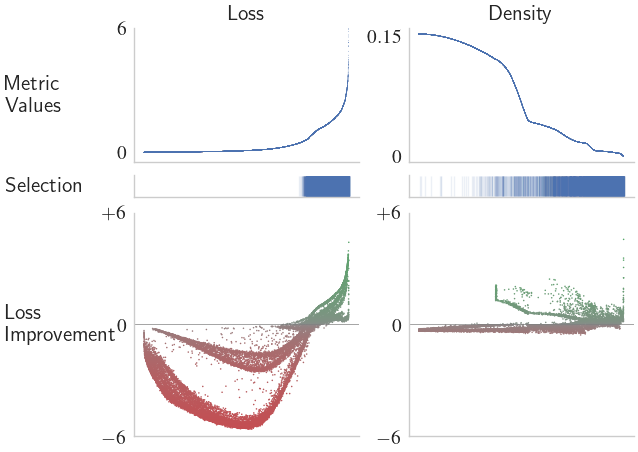

In [5]:
fig, axes = plt.subplots(
    3, 2,
    sharex=True, height_ratios=[0.6, 0.1, 1], constrained_layout=True,
    figsize=eh.plot_utils.default_size,
)
axes = np.array(axes)

sns.despine(fig, offset=0)

# Axis scaling.
max_loss = 6
max_improvement = 6
max_density = 0.15


_sl = np.argsort(selection_loss['loss_ref'])[::1]
_sd = np.argsort(selection_memento['density'])[::-1]
_x = np.arange(len(selection_memento['loss_ref']))

def color_by_improvement(improvement):
    improvement = np.array(improvement).reshape((-1, 1))
    green = np.array(sns.color_palette("deep")[2]).reshape((1, 3))
    red = np.array(sns.color_palette("deep")[3]).reshape((1, 3))
    grey = np.array(sns.color_palette("deep")[7]).reshape((1, 3))

    redgreen = np.where(improvement > 0, green, red)
    magnitude = np.abs(improvement).reshape((-1, 1)) ** (1/2)
    magnitude /= magnitude.max()

    return magnitude * redgreen + (1 - magnitude) * grey

# loss before selection
axes[0, 0].scatter(_x, selection_loss['loss_ref'][_sl], s=1,
                   rasterized=True) 
axes[0, 0].set(
    title="Loss",
    ylim=(None, max_loss),
    yticks=[0, max_loss],
    yticklabels=['$0$', f"${max_loss}$"],
)

# Which samples were selected
_lfraction = selection_loss['selected'].round()[_sl]
_lsub = _lfraction > 0
axes[1, 0].vlines(_x[_lsub], 0, 1, linewidth=1, alpha=0.1 * _lfraction[_lsub],
                  rasterized=True)
axes[1, 0].set(yticks=[])


# Logscore improvement after selection for loss
_improvement = (
    selection_loss['loss_ref'] - selection_loss['loss'])[_sl]
axes[2, 0].scatter(_x, _improvement, s=5,
                   c=color_by_improvement(_improvement),
                   rasterized=True)
axes[2, 0].axhline(0, color="gray", linewidth=0.5)
axes[2, 0].set(
    ylim=(-max_improvement, max_improvement),
    yticks=[-max_improvement, 0, max_improvement],
    yticklabels=[f"$-{max_improvement}$", "$0$", f"$+{max_improvement}$"],
    xticks=[],
)


# density before selection
axes[0, 1].scatter(_x, selection_memento['density'][_sd], s=1,
                   rasterized=True) 
axes[0, 1].set(
    title="Density",
    yticks=[0, max_density],
    yticklabels=['$0$', f"${max_density}$"],
)

# Which samples were selected
_fraction = selection_memento['selected'].round()[_sd]
_sub = _fraction > 0
axes[1, 1].vlines(_x[_sub], 0, 1, linewidth=1, alpha=0.1 * _fraction[_sub],
                  rasterized=True)
axes[1, 1].set(yticks=[])


#  Logscore improvement after selection for memento
_improvement = (
    selection_memento['loss_ref'] - selection_memento['loss'])[_sd]
axes[2, 1].scatter(_x, _improvement,
                   s=5, c=color_by_improvement(_improvement),rasterized=True)
axes[2, 1].axhline(0, color="gray", linewidth=0.5)

axes[2, 1].set(
    ylim=(-max_improvement, max_improvement),
    yticks=[-max_improvement, 0, max_improvement],
    yticklabels=[f"$-{max_improvement}$", "$0$", f"$+{max_improvement}$"],
    xticks=[],
)

# Polish presentation.
for ax in axes.flatten():
    ax.grid(False)

axes[0, 0].set_ylabel("Metric\nValues", rotation=0,
                      va="center", ha="left", labelpad=70)
axes[1, 0].set_ylabel("Selection", rotation=0,
                      va="center", ha="left", labelpad=70)
axes[2, 0].set_ylabel("Loss\nImprovement", rotation=0,
                      va="center", ha="left", labelpad=70)

fig.align_ylabels()
plt.savefig(plotdir / "selection_loss_matrix.pdf", dpi=300)
plt.show()

# Figure 9: Recurring patterns

With this experiment, we want to investigate whether patterns picked up by Memento recur after potentially long periods of time.

We allow Memento to select samples by replaying the first three weeks of 2022.
Afterwards, we freeze the selection.
For the rest of 2022, we compute the density of each of these batches with respect to the data of each new day. A high density means that the selected samples were prominent on this day, and vice versa.

We can observe both patterns with consistently high density as well as rare patterns that have generally low density but are recurring, and peak in irregular intervals, even after months.


In [6]:
# Implementation detail:
# Memento computes density in batches, so we can only compare the density over
# time in batches as well. We explore two 256 as well as 1024 samples per
# batch and plot the more fine-grained result (256 samples per batch).
freeze_stats = (
    eh.data.read_csv(resultdir / "freeze/memento/2022/stats.csv.gz")
    .dropna(subset=["density_mem_new_256"])
    .sort_values(by="iteration")
    .assign(
        n_batches_256=lambda df: df['density_new_mem_256'].map(len),
        # We also have batches of size 1024, but this is just less fine-grained.
        n_batches_1024=lambda df: df['density_new_mem_1024'].map(len)
    )
)

# density_mem_new is the density of in-memory samples w.r.t new samples, i.e.
# samples newly observed on every given day.
# Each row in the dataframe contains a string (value, value, ...)
# Eval these strings to get tuples and stack them into an array.
density_256 = np.stack(freeze_stats[f'density_mem_new_256'].map(eval)).T
print("(#batches x #days):", density_256.shape)

(#batches x #days): (3906, 207)


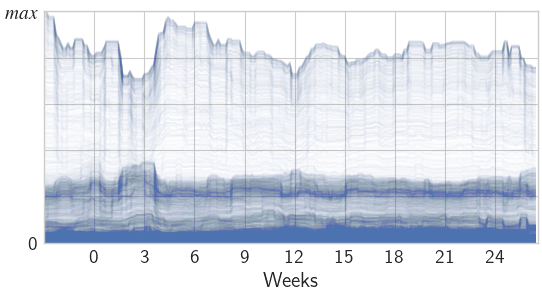

In [7]:
smoothed = ndimage.median_filter(density_256, size=(1, 7))
color = sns.color_palette("deep")[0]

fig, ax = plt.subplots(figsize=eh.plot_utils.default_size_short)

ax.plot(smoothed.T, color=color, alpha=0.01, linewidth=1)

xticks = np.arange(21, smoothed.shape[1], 21)  # three weeks
xticklabels = np.arange(0, len(xticks)) * 3


n_yticks=6
ymax = smoothed.max()
yticks = np.linspace(0, ymax, n_yticks)
yticklabels = [0, *([""] * (n_yticks -2)), r'$max$']
yticklabels

ax.set(
    xlabel="Weeks",
    #ylabel="Density",
    xlim=(0, smoothed.shape[1]), ylim=(0, ymax),
    xticks=xticks, xticklabels=xticklabels,
    yticks=yticks, yticklabels=yticklabels,
)

plt.savefig(plotdir / "density_over_time.pdf")
plt.show()